# **GirlSET Workshop: Brief Introduction to Software Engineering for Artificial Intelligence (SE4AI)**
# Machine learning (ML) with image data obtained from: https://github.com/iamcal/emoji-data

<div style="width:100%;text-align: center;">
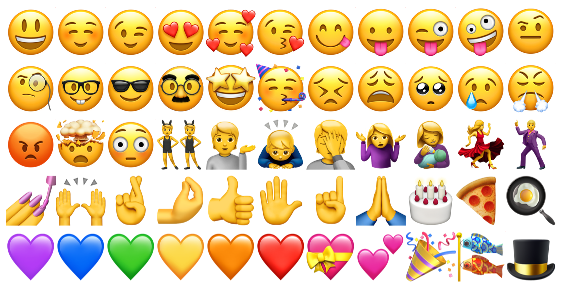
<\div> 

    In this tutorial, we will build an ML model that can predict an emoji's category based on its image characteristics. The goal of this workshop is to show how different ML models interpret data and how to know when we have found our best model. The following outlines the general steps:  

    Step 0: Setup Notebook 
    Step 1: Retrieve and understand the data 
    Step 2: Prepare the data 
    Step 3: Experiment with different ML models and configurations 
    Step 4: Examine the models' results


Image source: https://getemoji.com/assets/og/mobile.png

# Step 0: Setup Notebook

Please run the code cells below by pressing the ***Shift*** and ***Enter*** buttons at the same time. You can also press the ***Play*** button found on the left side of the code box.

Once the loading circle is complete, click on the next code cell. From here, you should see **[#]** where **#** indicates the number of runs.

In [ ]:
"""
These are the libraries we will be using in this tutorial.
"""

import os                        # checks if a file exists
import json                      # loads metadata
import urllib                    # downloads remote files
import numpy as np               # helpful math-based library

import matplotlib as mpl         # displays the images and results
import matplotlib.pyplot as plt  # helper to ^ to build the plots/graphs

import sklearn                   # popular machine learning library
import sklearn.tree
import sklearn.metrics           # evaluates the model's performance
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.neural_network

import torch

plt.rcParams.update({'figure.max_open_warning': 0})   # silences any warnings for too many open figures

In [ ]:
"""
These are global variables which will make it easier to modify throughout the code
"""
SHEET_SIZE = 64                                     # describes the size of our sheet (16, 32, 64 - the higher value = better quality)
PADDING = SHEET_SIZE+2                              # as described in the library, there are two 1-pixel transparent borders around the emoji image

"""
These are methods that do specific functions and will help during the tutorial.
"""

def download(url: str, local_file: str):
    """
    Download a file with a name that is accessible by a URL (unless the file already exists)
    Returns the localfile string.
    """
    if not os.path.exists(local_file):                                                  # check if file already exists
        print("Downloading %s..." % local_file)                                         # if true, print message and continue
        filename, headers = urllib.request.urlretrieve(url, local_file)                 # download file from URL with the given local_file name
        print("Downloading %s is complete!" % local_file)                               # print finished message

# Step 1: Retrieve and understand the data

Data is one of the most important factors of building ML systems as it influences the predictions of the model.  

Our ML model will need some data to learn and make predictions from. First, we will download the sheet image containing all emojis made by Google. 

**Run the following code cell** to download and display the image sheet holding all the emojis made by Google. 

In [ ]:
if not os.path.exists('emojis'):                      # checks if 'emojis' folder already exists
    os.mkdir('emojis')                                # if true, creates a new folder called *emojis* to hold the picture and metadata of emojis

# downloads the picture of all emojis and the corresponding metadata 
download('https://github.com/iamcal/emoji-data/raw/master/sheets-clean/sheet_google_{}_clean.png'.format(SHEET_SIZE), 'emojis/google.png')
download('https://github.com/iamcal/emoji-data/raw/master/emoji.json', 'emoji.json')

# retrieves the metadata
file = open('emoji.json', "r")                             # open the file containing the emoji metadata
METADATA = np.array(json.loads(file.read()))               # read the file and save it in an array 
file.close()                                               # close the file
    
# displays the emojis in a plot
fig = plt.figure(figsize=(20, 20))                   # makes the plot bigger so it's easier to see
IMG_EMOJIS = plt.imread('emojis/google.png')         # save image as a global variable 
plt.imshow(IMG_EMOJIS);                              # displays the image in a plot

As we can see, there are a lot of emojis! How can we break this down to view emojis of some certain groups (categories) instead?

Let's take a look at the *metadata*! 

In the following code block, **write the code to print the first value stored in the METADATA variable.** 

***Hint:*** remember the first index of an array!

\
Once done, what are some important attributes that you notice for this emoji?

In [ ]:
# Type code here


Now that we understand the metadata structure a bit better, we can use it to display an emoji from any of the available categories. 

Using the metadata, we can find all possible emoji categories.

**Run the following code cell** to see a list of all categories.

In [ ]:
# categories in regular form
categories = np.unique([emoji['category'] for emoji in METADATA]) 
print(categories)

From the above list, we can try to get the names of the emojis that fall under a certain category.

**Run the following code cell** to define the *get_emoji_names_given_category*  method to help us find all the emoji names given a category (*input_category*).

In [ ]:
def get_emoji_names_given_category(input_category: str):
    """
    This method finds all the emoji names that fall under a certain category
    Returns a list containing all affiliated emoji names 
    """
    # check if input category is in category list
    if input_category in categories:                            
        
        # get all the names of emojis that have this category
        emoji_names = [dictionary['name'] for dictionary in METADATA if dictionary['category'] == input_category ]                  
        
        # return the names
        return emoji_names
    
    else:
        # display an error message to the user
        print('The supplied category name does not exist')

Great! Now we can display the emoji names by giving the method a parameter value.

**Write the code** to print all the category names using the above function.

In [ ]:
# Type code here


**Run the following code cell** to define the following methods:
* *get_emoji_location*
* *get_emoji_image*
* *display_emoji*
* *rgba_to_rgb*

In [ ]:
def get_emoji_location(emoji_name: str):
    """
    This method finds the x and y coordinates of an emoji on the sheet image based on a given name.
   
    Returns a tuple containing the x and y location of the emoji
    """
    
    # find the index where the emoji's name is in the METADATA
    try:
        ind = next((index for (index, d) in enumerate(METADATA) if d['name'].casefold() == emoji_name.casefold()), None)

        # use index to get sheet_x and sheet_y values
        x_coord = METADATA[ind]['sheet_x']       
        y_coord = METADATA[ind]['sheet_y']
        
        # return the coordinates in [x, y] format
        return [x_coord, y_coord]

    # if an error occurs, code will stop and print the following message     
    except:
        print('{} is not a valid emoji name'.format(emoji_name))
        

def get_emoji_image(emoji_index):
    """
    This method returns the emoji image based on the provided index in the sheet data
    """
    return IMG_EMOJIS[emoji_index[1] * PADDING+1:(emoji_index[1]+1) * PADDING-1,    #TODO: fix code to represent github code
                      emoji_index[0] * PADDING+1:(emoji_index[0]+1) * PADDING-1]

        
def display_emoji(title, emoji_image):
    """
    This method displays an emoji's name and image in a plot.
    title represents the name of the emoji.
    emoji_image represents the image returned from the get_emoji_image method. 
    """
    plt.title(title)
    plt.imshow(emoji_image)


def rgba_to_rgb(emoji_image):
    """
    This method transforms the emoji image from rgba to rgb. 
    The purpose of this is to make the image interpretable by the model.
    """
    rgb, a = np.split(emoji_image, [3], axis=2)  # Split into (H,W,3) and (H,W,1)
    return (1-a) + a*rgb                         # Apply alpha blending to get RGB

Last step!

**Write the code** to call the above methods using one of the listed emoji names from before.

***Hint:*** double-click on any of the emoji names to highlight the full text. Then just copy it into the method as a parameter 😊.

In [ ]:
# Type code here


At this stage, we should have a better understanding of how to map the metadata to each emoji shown in the image sheet.


### Takeaways from this step:
* The *sheet image* is an image that contains all emojis.
* The *metadata* holds important information for each emoji shown in the *sheet image*. For example, we can see **which emoji belongs to which category**.
* Each emoji has its own x and y coordinates to help us find the image in the *sheet image*.

# Step 2: Prepare the data

The goal of this step is to understand how to properly prepare the data for the ML models to interpret and make predictions. The outline of this section is listed as such:

#### 1. Get the *input images* for each emoji shown in the sheet image.
#### 2. Establish the *targets* for each emoji mentioned in the METADATA.
#### 3. Split the data before showing it to our ML models.
#### 4. Pre-process the image data.

### 1. Get the *input images* for each emoji shown in the sheet image.

Our first step is to separate and save each emoji image from the *sheet image*. This data will be used as the *input* of our ML model.

**Run the following code cell** to create the ***X*** 

In [ ]:
X = []

# loop over each emoji from the metadata while maintaining its index
for emoji_index, emoji_image in enumerate(METADATA):

    # group the x and y indicies signified by the json file
    x_y_indicies = [emoji_image['sheet_x'], emoji_image['sheet_y']]
    
    # transform the emoji image from rgba to rgb
    fixed_emoji_image = rgba_to_rgb(get_emoji_image(x_y_indicies))
        
    # include the current emoji image in the input array after modifying its dimensions
    X.append(fixed_emoji_image)

# reshape the array to be interpetable by the model
X = np.array(X).reshape(1854, 12288)

### 2. Establish the *targets* for each emoji mentioned in the METADATA.

For our tutorial, the *target* represents the prediction we want the ML model to make when it sees a certain emoji. 

Typically, the list of targets are stored in a variable called ***y***. To make this simpler, we will use a variable called ***y_targets*** which will save each emoji's category type in the same order as the METADATA array.

**Run the following code cell** to get the corresponding category types for each emoji mentioned in the METADATA. We will save these values in a variable called ***y_targets***.

In [ ]:
# transform our list of categories into numerical representations
# example: 0 = 'Activities'
dict_enum_categories = { categories[i] : i  for i in range(0, len(categories)) }

# get the emoji categories in the same order as X
y_targets = [emoji['category'] for emoji in METADATA]

# transform the text-representation of the categories to numerical values
# Purpose: it is easier for the model to interpret.
y_targets = [dict_enum_categories[target] for target in y_targets]

**Write the code** to print the values stored in the ***y_targets*** variable.

In [ ]:
# Type code here

Now that we saw how an ML model can interpret the data and make predictions by using ***target*** values, we can start to process the data.

### 3. Split the data before showing it to our ML models.

As explained in the slides, we need to divide our data into the three mentioned groups (*train*, *validation*, and *test*).

We will split the ***X*** variable containing all emoji images using a similar naming convention where:
* ***X_train:*** represents the training dataset obtained from splitting the METADATA.
* ***X_validation:*** represents the validation dataset.
* ***X_test:*** represents the test dataset.

As we also mentioned before, the ***y*** variable typically represents the *targets* for each value in the data. Therefore:
* ***y_train:*** represents the targets for the X_train dataset.
* ***y_validation:*** represents the targets for the X_validation dataset.
* ***y_test:*** represents the targets for the X_test dataset.

**Run the following code cell** to split the METADATA into the three mentioned groups (*train, validation,* and *test*).

A good rule of thumb is to **randomly separate** the data into the following composition:
* **60%** of the data goes to the *training* set.
* **20%** of the data goes to the *validation* set.
* **20%** of the data goes to the *testing* set.

In [ ]:
# first split the data into 60% train and 40% validation
X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(X, y_targets, train_size=0.6, test_size=0.4, random_state=0)

# then split the 40% evenly between the validation and test sets
X_test, X_validation, y_test, y_validation = sklearn.model_selection.train_test_split(X_validation, y_validation, train_size=0.5, test_size=0.5, random_state=0)

### 4. Pre-process the image data

The last phase of this step is to modify the image data in a way that can make interpretations easier for the ML model.

For example, you may have noticed that all of our emoji images have *different shapes and colors*, but *all have a white background*. Also, some emojis from different categories can share similar shapes and colors, which can be misleading to the model.

Therefore, we will apply ***normalization*** to the images stored in the ***X*** variable.

**Run the following code cells** to:

1. Display an emoji from the ***X_train*** set before applying normalization.
2. Apply the normalization to the image.
3. See the example image after being normalized.

In [ ]:
display_emoji('Before normalization', X_train[32].reshape(64,64,3))

In [ ]:
# create the link to the library that supports normalization 
# and fit the training data to it
STD_SCALER = sklearn.preprocessing.StandardScaler()
STD_SCALER.fit(X_train)

# normalize all the image data (X)
X_train = STD_SCALER.transform(X_train)
X_validation = STD_SCALER.transform(X_validation)
X_test = STD_SCALER.transform(X_test)

# display the results
display_emoji('After normalization', X_train[32].reshape(64,64,3))

### **Questions:** 

* What shapes do you notice in the "**After normalization**" plot? 
* Why do you think they appear even when our example follows a different shape?

We reached the end of this step! 🎉

At this stage, we should understand why it's important to separate our data into certain groups and how to do it properly.


### Takeaways from this step:
* We needed to break down our original data to have:
   * The emoji images (which will be the ***input*** for our ML models).
   * The corresponding emojis' category (which will the ***targets*** for what we want our ML models to predict).
   
   
* The *training* data is used for the model to learn how to properly classify emojis.
* The *validation* data is used to pick the best configuration for our model.
* The *test* data is used to evaluate our final model.
* *Normalizing* the emoji images makes it easier for the ML models to interpret. This is used to highlight important characteristics in the image (ex. colors, shape outlines, shadows, etc.)

# Step 3: Experiment with different ML models and configurations 

The goal of this step is to build some examples of simple and complex ML models. In this step, we will examine the following models:

#### 1. Decision trees
#### 2. Random forest
#### 3. Logistic regression
#### 4. Neural network (NN)
#### 5. Convolutional neural network (CNN)

\
Note: there are many more ML models, but we will only consider these for this tutorial.

**Run the following code cell** to define the *plot_results* methods.

In [ ]:
def plot_results(model_name, model_results, hyper_param, hyper_param_values):
    """
    This method is used to plot the results of the input model and given hyper-parameters
    This method should only be ran after the model has been trained
    """
    # set the range for the x-axis
    x_axis = np.arange(len(hyper_param_values)) * int(100/(len(hyper_param_values))) + 20
    
    # plot the results
    plt.plot(x_axis, model_results, marker='o', color='r', label='validation set')
    plt.title('{} - Accuracy Results'.format(model_name))
    plt.ylim([0.0,1.05])
    plt.xlabel(hyper_param)
    plt.ylabel('score')
    plt.show()    

#### 1. Decision trees
 
Here are some examples of trying out different values [1, 5, 10, 50, 100] for the ***max_depth*** hyper-parameter of a decision tree. 

**Run the following code cell** to train different decision trees and see their performance (in terms of **accuracy**) of the validation set.

In [ ]:
decision_tree_results = []

for max_depth_value in [1, 5, 10, 50, 100]:
    decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth_value, random_state=0).fit(X_train, y_train)
    result = decision_tree.score(X_validation, y_validation)
    decision_tree_results.append(result)
    print('Decision tree results for max_depth = {}: {:.3f}%'.format(max_depth_value, result*100))
    
print('\n')
plot_results('Decision Trees', decision_tree_results, 'max_depth', [1, 5, 10, 50, 100])

**Question**: which configuration would you select for this model? Why?

In [ ]:
#Type answer here


Let's look at a simpler example of a decision tree. 

**Run the following code cell** to see a simple decision tree with a **max_depth of 3 levels** [0, 1, 2].

In [ ]:
plt.figure(figsize=(12,12))
sklearn.tree.plot_tree(sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train, y_train), fontsize=10)
plt.show();

#### 2. Random forest

Here are some examples of trying out different values [1, 5, 10, 50, 100] for the ***max_depth*** hyper-parameter of a random forest. 

**Run the following code cell** to train different random forests and see their performance (in terms of **accuracy**) of the validation set.

In [ ]:
random_forest_results = []

for max_depth_value in [1, 5, 10, 50, 100]:
    random_forest = sklearn.ensemble.RandomForestClassifier(max_depth=max_depth_value, random_state=0).fit(X_train, y_train)
    result = random_forest.score(X_validation, y_validation)
    random_forest_results.append(result)
    print('Random forest results for max_depth = {}: {:.3f}%'.format(max_depth_value, result*100))
    
print('\n')
plot_results('Random Forests', random_forest_results, 'max_depth', [1, 5, 10, 50, 100])

**Question**: which configuration would you select for this model? Why?

In [ ]:
#Type answer here


#### 3. Logistic regression

Here are some examples of trying out different values [0.0001, 0.001, 0.01, 0.1, 1] for the ***C*** hyper-parameter of a logistic regression classifier. 

**Run the following code cell** to train different logistic regressors and see their performance (in terms of **accuracy**) of the validation set.

***Note:*** this model may take a bit of time to train!

In [ ]:
logistic_regression_results = []

for C_value in [0.0001, 0.001, 0.01, 0.1, 1]:
    logistic_regression = sklearn.linear_model.LogisticRegression(max_iter=10000, C=C_value, random_state=0).fit(X_train, y_train)
    result = logistic_regression.score(X_validation, y_validation)
    logistic_regression_results.append(result)
    print('Logistic regression results for C = {}: {:.3f}%'.format(C_value, result*100))
    
print('\n')
plot_results('Logistic Regressions', logistic_regression_results, 'C', [0.0001, 0.001, 0.01, 0.1, 1])

**Question**: which configuration would you select for this model? Why?

In [ ]:
# Type answer here


#### 4. Neural Network - Multi-Layer Perceptron (MLP)

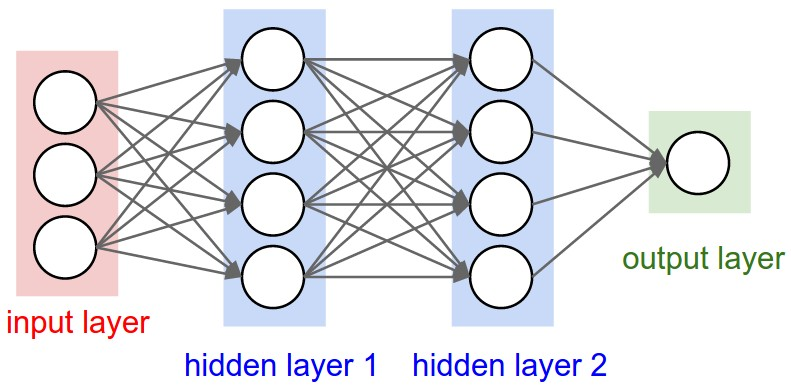

Here are some examples of trying out different values [0.0001, 0.001, 0.01, 0.1, 1] for the ***alpha*** hyper-parameter of a MLP neurnal network. 

**Run the following code cell** to train different neural networks and see their performance (in terms of **accuracy**) of the validation set.


Image source: https://cs231n.github.io/convolutional-networks/

In [ ]:
MLP_neural_network_results = []

for alpha_value in [0.0001, 0.001, 0.01, 0.1, 1]:
    MLP_neural_network = sklearn.neural_network.MLPClassifier(
        hidden_layer_sizes=(4,4,),
        alpha=alpha_value,
        random_state=0).fit(X_train, y_train)
    result = MLP_neural_network.score(X_validation, y_validation)
    MLP_neural_network_results.append(result)
    print('MLP Neural Network results for alpha = {}: {:.3f}%'.format(alpha_value, result*100))
    
print('\n')
plot_results('MLP Neural Network', MLP_neural_network_results, 'alpha', [0.0001, 0.001, 0.01, 0.1, 1])

**Question**: which configuration would you select for this model? Why?

In [ ]:
# Type answer here


#### 5. Convolutional Neural Network (CNN)

This final model is interpreted a bit differently from the other models. 

Instead of trying out various hyper-parameter values, we will give the model small ***batches*** of data and see how it handles it over ***5*** runs. 

We measure performance in this model with a new term called ***loss***. The general goal of this measure is to get the a loss ***as close to 0 as possible***.

**Run the following code cell** to train different logistic regressors and see their performance (in terms of **accuracy**) of the validation set.

In [ ]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

num_filter = 8
filter_size = (2,2)

model = torch.nn.Sequential(
 torch.nn.Conv2d(3, num_filter, filter_size, padding=2),
 torch.nn.ReLU(),
 torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
 torch.nn.Flatten(),
 torch.nn.Linear(8712, 1112)
)

testing_tester_X = torch.tensor(X_train.reshape(-1,3,64,64), dtype=torch.float32)
testing_tester_y = torch.tensor(y_train, dtype=torch.float32)

y_pred = model(testing_tester_X)
y_pred = y_pred[:, 0]

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.05,momentum=0.9,
                            weight_decay=0.001)

batch_size = 500
num_epoch = 5
next_epoch = 1

for epoch in range(next_epoch, next_epoch+num_epoch):
    for i in range(0, len(X_train), batch_size):
        X = testing_tester_X[i:i+batch_size]
        y = testing_tester_y[i:i+batch_size]
        y_pred_inner = model(X)
        l = loss(y_pred_inner[:, 0], y)

        model.zero_grad()
        l.backward()
        optimizer.step()
    print('Epoch {:} final minibatch had loss {:0.4}'.format(epoch, l.item()))

next_epoch = epoch+1

**Question**: which configuration would you select for this model? Why?

In [ ]:
# Type answer here


We reached the end of this tutorial! 🎉